In [76]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Load datasets

In [33]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

<ipython-input-33-525dda771c74>:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train.csv')


In [34]:
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)

Train Data Shape: (46618, 64)
Test Data Shape: (4970, 63)


Data Preparation

In [35]:
df_cleaned = train_data.copy()
df_cleaned_test = test_data.copy()

Check for missing values

In [36]:
missing_data = df_cleaned.isnull().sum()
print("Missing Values Before Handling:\n", missing_data[missing_data > 0])

Missing Values Before Handling:
 yr                       292
ht                        64
num                     4679
Rec_Rank               32281
ast_tov                 3467
rimmade                 5758
rimmade_rimmiss         5758
midmade                 5758
midmade_midmiss         5758
rim_ratio               8499
mid_ratio               8568
dunksmade               5758
dunksmiss_dunksmade     5758
dunks_ratio            26218
pick                   45411
drtg                      42
adrtg                     42
dporpag                   42
stops                     42
bpm                       42
obpm                      42
dbpm                      42
gbpm                      42
mp                        36
ogbpm                     42
dgbpm                     42
oreb                      36
dreb                      36
treb                      36
ast                       36
stl                       36
blk                       36
pts                       36
dtype: int

Dropping columns with maximum missing values

In [37]:
cols_to_drop = [
    'Rec_Rank', 'ast_tov', 'rimmade', 'rimmade_rimmiss', 'midmade',
    'midmade_midmiss', 'rim_ratio', 'mid_ratio', 'dunksmade', 'dunksmiss_dunksmade',
    'dunks_ratio'
]

In [38]:
df_cleaned.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [39]:
df_cleaned_test.drop(columns=cols_to_drop, inplace=True, errors='ignore')

Ensure columns are consistent between train and test


In [40]:
common_columns = df_cleaned.columns.intersection(df_cleaned_test.columns).tolist()

In [41]:
common_columns

['team',
 'conf',
 'GP',
 'Min_per',
 'Ortg',
 'usg',
 'eFG',
 'TS_per',
 'ORB_per',
 'DRB_per',
 'AST_per',
 'TO_per',
 'FTM',
 'FTA',
 'FT_per',
 'twoPM',
 'twoPA',
 'twoP_per',
 'TPM',
 'TPA',
 'TP_per',
 'blk_per',
 'stl_per',
 'ftr',
 'yr',
 'ht',
 'num',
 'porpag',
 'adjoe',
 'pfr',
 'year',
 'type',
 'pick',
 'drtg',
 'adrtg',
 'dporpag',
 'stops',
 'bpm',
 'obpm',
 'dbpm',
 'gbpm',
 'mp',
 'ogbpm',
 'dgbpm',
 'oreb',
 'dreb',
 'treb',
 'ast',
 'stl',
 'blk',
 'pts',
 'player_id']

In [42]:
common_columns = [col for col in common_columns if col != 'player_id']

In [43]:
common_columns

['team',
 'conf',
 'GP',
 'Min_per',
 'Ortg',
 'usg',
 'eFG',
 'TS_per',
 'ORB_per',
 'DRB_per',
 'AST_per',
 'TO_per',
 'FTM',
 'FTA',
 'FT_per',
 'twoPM',
 'twoPA',
 'twoP_per',
 'TPM',
 'TPA',
 'TP_per',
 'blk_per',
 'stl_per',
 'ftr',
 'yr',
 'ht',
 'num',
 'porpag',
 'adjoe',
 'pfr',
 'year',
 'type',
 'pick',
 'drtg',
 'adrtg',
 'dporpag',
 'stops',
 'bpm',
 'obpm',
 'dbpm',
 'gbpm',
 'mp',
 'ogbpm',
 'dgbpm',
 'oreb',
 'dreb',
 'treb',
 'ast',
 'stl',
 'blk',
 'pts']

Define features

In [44]:
numerical_features = df_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = df_cleaned.select_dtypes(include=['object']).columns.tolist()

Remove 'drafted' from features for prediction


In [45]:
numerical_features

['GP',
 'Min_per',
 'Ortg',
 'usg',
 'eFG',
 'TS_per',
 'ORB_per',
 'DRB_per',
 'AST_per',
 'TO_per',
 'FTM',
 'FTA',
 'FT_per',
 'twoPM',
 'twoPA',
 'twoP_per',
 'TPM',
 'TPA',
 'TP_per',
 'blk_per',
 'stl_per',
 'ftr',
 'porpag',
 'adjoe',
 'pfr',
 'year',
 'pick',
 'drtg',
 'adrtg',
 'dporpag',
 'stops',
 'bpm',
 'obpm',
 'dbpm',
 'gbpm',
 'mp',
 'ogbpm',
 'dgbpm',
 'oreb',
 'dreb',
 'treb',
 'ast',
 'stl',
 'blk',
 'pts',
 'drafted']

In [46]:
categorical_features

['team', 'conf', 'yr', 'ht', 'num', 'type', 'player_id']

In [47]:
numerical_features = [col for col in numerical_features if col != 'drafted']

In [48]:
categorical_features = [col for col in categorical_features if col != 'player_id']

Check if all specified columns exist in both DataFrames


In [49]:
missing_in_train = set(numerical_features + categorical_features) - set(df_cleaned.columns)
missing_in_test = set(numerical_features + categorical_features) - set(df_cleaned_test.columns)

In [50]:

print(f"Missing columns in training data: {missing_in_train}")
print(f"Missing columns in test data: {missing_in_test}")

Missing columns in training data: set()
Missing columns in test data: set()


Convert mixed-type columns to strings

In [51]:
for col in categorical_features:
    df_cleaned[col] = df_cleaned[col].astype(str)
    df_cleaned_test[col] = df_cleaned_test[col].astype(str)

Define transformers

In [52]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [53]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


Define the preprocessor

In [54]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

Prepare features and labels

In [55]:
X_train = df_cleaned.drop(columns=['player_id', 'drafted'])
y_train = df_cleaned['drafted']
X_test = df_cleaned_test.drop(columns=['player_id'])

Ensure features are aligned

In [56]:
print("Columns in X_train:")
print(X_train.columns.tolist())
print("Columns in X_test:")
print(X_test.columns.tolist())
print("Common columns:")
print(common_columns)

Columns in X_train:
['team', 'conf', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA', 'FT_per', 'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per', 'blk_per', 'stl_per', 'ftr', 'yr', 'ht', 'num', 'porpag', 'adjoe', 'pfr', 'year', 'type', 'pick', 'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp', 'ogbpm', 'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts']
Columns in X_test:
['team', 'conf', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA', 'FT_per', 'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per', 'blk_per', 'stl_per', 'ftr', 'yr', 'ht', 'num', 'porpag', 'adjoe', 'pfr', 'year', 'type', 'pick', 'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp', 'ogbpm', 'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts']
Common columns:
['team', 'conf', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per', 'ORB_per', 'DRB_per',

Ensure features are aligned

In [57]:
X_train = X_train[common_columns]
X_test = X_test[common_columns]

Split the data into training and validation sets

In [58]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Apply transformations

In [59]:
print("\nColumnTransformer steps:")
for name, transformer, columns in preprocessor.transformers:
    print(f" - {name}: {columns}")


ColumnTransformer steps:
 - num: ['GP', 'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA', 'FT_per', 'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per', 'blk_per', 'stl_per', 'ftr', 'porpag', 'adjoe', 'pfr', 'year', 'pick', 'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp', 'ogbpm', 'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts']
 - cat: ['team', 'conf', 'yr', 'ht', 'num', 'type']


In [60]:
print('player_id' in X_train.columns)
print('player_id' in X_test.columns)
print ('player_id' in X_val.columns)

False
False
False


Find the index of the transformer that was operating on 'player_id'

apply transformations

In [61]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

In [62]:
print("\nTransformed X_train shape:", X_train_transformed.shape)
print("Transformed X_val shape:", X_val_transformed.shape)
print("Transformed X_test shape:", X_test_transformed.shape)


Transformed X_train shape: (37294, 561)
Transformed X_val shape: (9324, 561)
Transformed X_test shape: (4970, 561)


Train Polynomial Regression Model


Import polynomialfeatures

In [63]:
from sklearn.preprocessing import PolynomialFeatures

In [64]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_transformed)
X_val_poly = poly.fit_transform(X_val_transformed)
X_test_poly = poly.transform(X_test_transformed)

Import Logistic Rregression

In [65]:
from sklearn.linear_model import LogisticRegression

In [66]:
poly_model = LogisticRegression(max_iter=10000, random_state=42)
poly_model.fit(X_train_poly, y_train)

LogisticRegression(max_iter=10000, random_state=42)


# Predict probabilities

Prediction Probability in training set

In [67]:
y_train_pred_prob = poly_model.predict_proba(X_train_poly)[:, 1]

Predict Probability in Validation Set

In [70]:
y_val_pred_prob = poly_model.predict_proba(X_val_poly)[:, 1]

Calculate AUROC on the training set

Import AUROC

In [71]:
from sklearn.metrics import roc_auc_score

In [72]:
train_auc = roc_auc_score(y_train, y_train_pred_prob)
print(f"Polynomial Regression Model (Degree=2) Training AUROC: {train_auc}")

Polynomial Regression Model (Degree=2) Training AUROC: 1.0


In [73]:
val_auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"Polynomial Regression Model (Degree=2) Validation AUROC: {val_auc}")

Polynomial Regression Model (Degree=2) Validation AUROC: 0.978292531499696


Plot AUROC Curve

In [74]:
from sklearn.metrics import roc_auc_score, roc_curve

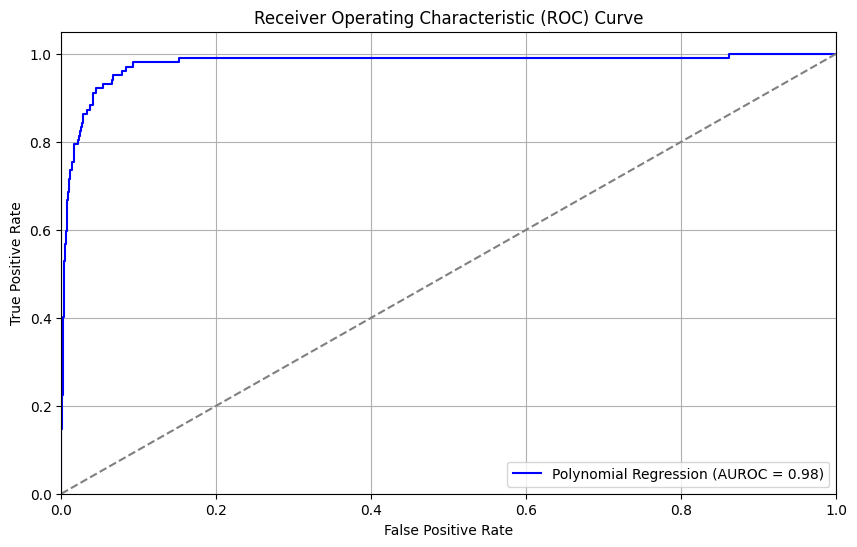

In [77]:
fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='Polynomial Regression (AUROC = {:.2f})'.format(val_auc))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [78]:
print(y_train)

42016    0.0
4048     0.0
33056    0.0
44025    0.0
27493    0.0
        ... 
11284    0.0
44732    0.0
38158    0.0
860      0.0
15795    0.0
Name: drafted, Length: 37294, dtype: float64


In [79]:
test_pred_prob = poly_model.predict_proba(X_test_poly)[:, 1]

 Prepare submission DataFrame

In [83]:
submission = pd.DataFrame({
    'player_id': df_cleaned_test['player_id'],
    'drafted': test_pred_prob
})

In [84]:
submission.to_csv('submission.csv', index=False)